# Multinomial Logistic Regression - Wine

## Import Libraries

In [1]:
import warnings  # Suppress warnings

warnings.filterwarnings("ignore")

import os  # Interact with the operating system.
import sys  # Read system parameters.
from io import StringIO  # Read and write strings as files
from time import time
from urllib.parse import urlparse  # Parse URL and extract path component

import matplotlib as mpl  # Create 2D charts.
import matplotlib.pyplot as plt
import numpy as np  # Work with multi-dimensional arrays and matrices.
import pandas as pd  # Manipulate and analyze data frames.
import requests  # Send HTTP requests
import seaborn as sns  # Streamline charting.
import sklearn  # Perform feature engineering and machine learning.
from scipy.stats import zscore
from sklearn import datasets  # ML datasets
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Summarize software libraries used.
print("Libraries used in this project:")
print("- NumPy {}".format(np.__version__))
print("- pandas {}".format(pd.__version__))
print("- scikit-learn {}".format(sklearn.__version__))
# print("- Matplotlib {}".format(matplotlib.__version__))
print("- Seaborn {}".format(sns.__version__))
print("- Python {}\n".format(sys.version))
print("\nSummary of software packages complete.\n")

Libraries used in this project:
- NumPy 1.24.3
- pandas 2.0.3
- scikit-learn 1.3.2
- Seaborn 0.9.0
- Python 3.8.18 | packaged by conda-forge | (default, Dec 23 2023, 17:23:49) 
[Clang 15.0.7 ]


Summary of software packages complete.



## Load Wine dataset.


In [2]:
wine = datasets.load_wine()
print("Loaded {} wine records.".format(len(wine.data)))

Loaded 178 wine records.


**Convert array to pandas DataFrame.**

In [3]:
df = pd.DataFrame(wine["data"], columns=wine["feature_names"])
df["target"] = wine["target"]

**Shuffle the dataset.**

In [4]:
df = shuffle(df.copy(), random_state=765)
df.reset_index(inplace=True, drop=True)

## Explore Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

**Spotlights** 

- The dataset comprises 178 entries and 14 features.
- All features are represented as floating-point numbers, with the exception of the target feature, which consists of integer values. This target feature indicates the wine classification, categorized as 0, 1, or 2, thus creating a multi-class classification challenge.
- There are no instances of missing data; every entry is complete across all features.
- The majority of the features pertain to the chemical properties of the wine, such as alcohol content, magnesium concentration, and phenol count. Additionally, some features relate to the visual characteristics of the wine, including color intensity and hue.
- Overall, the dataset is quite clean and consistent, although it could still benefit from some preparatory steps.

**Examine the First 5 Records**

In [6]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,13.69,3.26,2.54,20.0,107.0,1.83,0.56,0.50,0.80,5.88,0.96,1.82,680.0,2
1,12.67,0.98,2.24,18.0,99.0,2.20,1.94,0.30,1.46,2.62,1.23,3.16,450.0,1
2,13.86,1.35,2.27,16.0,98.0,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045.0,0
3,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0
4,13.41,3.84,2.12,18.8,90.0,2.45,2.68,0.27,1.48,4.28,0.91,3.00,1035.0,0


### Analyze Summary Statistics

In [7]:
with pd.option_context("float_format", "{:.2f}".format):
    print(df.describe())

       alcohol  malic_acid    ash  alcalinity_of_ash  magnesium  \
count   178.00      178.00 178.00             178.00     178.00   
mean     13.00        2.34   2.37              19.49      99.74   
std       0.81        1.12   0.27               3.34      14.28   
min      11.03        0.74   1.36              10.60      70.00   
25%      12.36        1.60   2.21              17.20      88.00   
50%      13.05        1.87   2.36              19.50      98.00   
75%      13.68        3.08   2.56              21.50     107.00   
max      14.83        5.80   3.23              30.00     162.00   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count         178.00      178.00                178.00           178.00   
mean            2.30        2.03                  0.36             1.59   
std             0.63        1.00                  0.12             0.57   
min             0.98        0.34                  0.13             0.41   
25%             1.74 

- A lack of expertise in wine or an understanding of alcohol chemistry, may make it challenging to discern which characteristics are crucial for classifying wine.
- The data does not seem to present significant outliers for any of the characteristics, but a visual distribution will provide further clarity.
- It is evident that the levels of magnesium and particularly proline are considerably higher compared to other features, indicating that some scaling may be necessary.

## Analyze Feature Distributions
- A deeper analysis of the data could enhance your understanding of the key factors influencing wine classification.
- Visual representations of the data will aid in identifying trends and anomalies that may not be immediately apparent.

**Plot histograms**

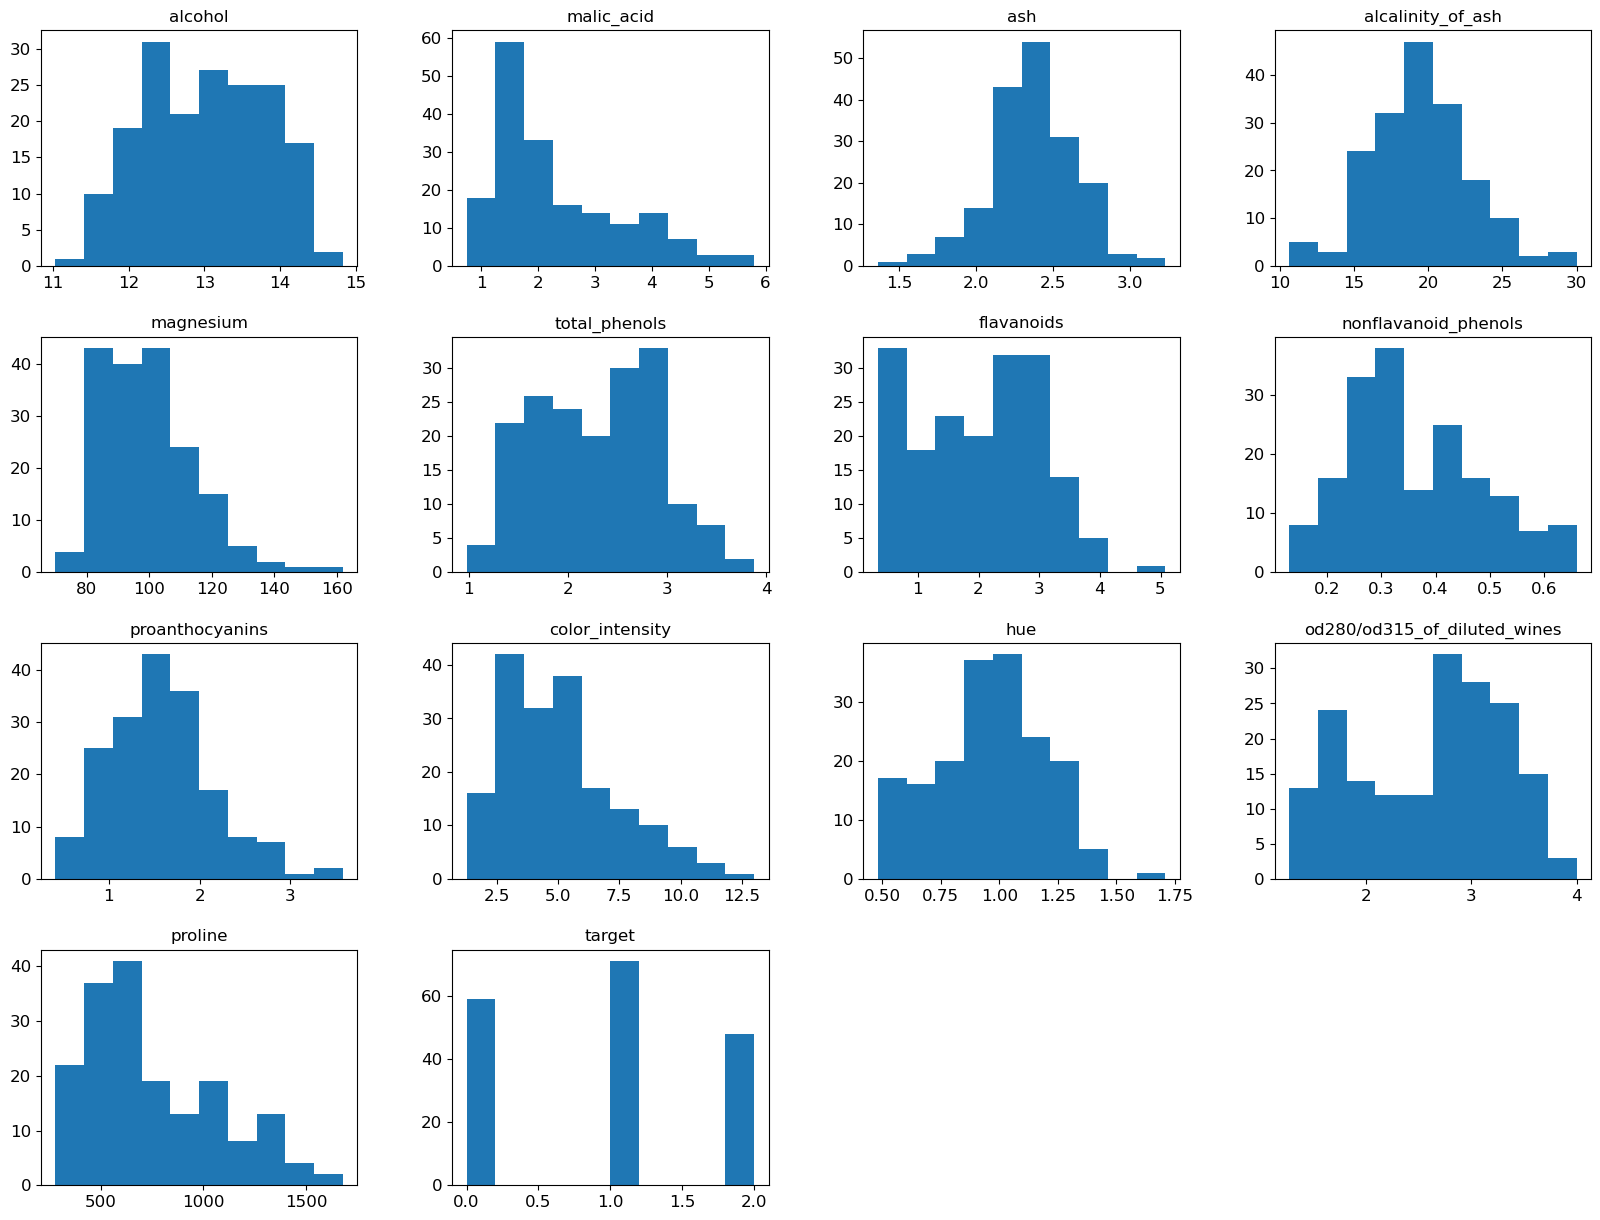

<Figure size 640x480 with 0 Axes>

In [8]:
%matplotlib inline
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

df.hist(
    figsize=(20, 15),
    grid=False,
)
plt.figure();

- Generally, the histograms support the notion that the dataset lacks significant extreme outliers.
- Certain features, including malic_acid and color_intensity, display a noticeable right skew.
- Additionally, the distribution of class labels (target) appears to be relatively balanced. 
- Overall, the visual representations indicate a consistent pattern across the data.
- The analysis suggests that while some features show skewness, the overall outlier presence is minimal.

**Analyze 'target' class counts**

In [9]:
target_class_counts = df["target"].value_counts()

print("(Class 0):", target_class_counts[0], "\n")
print("(Class 1):", target_class_counts[1], "\n")
print("(Class 2):", target_class_counts[2], "\n")

(Class 0): 59 

(Class 1): 71 

(Class 2): 48 



<Axes: title={'center': 'Count (taret)'}, xlabel='target'>

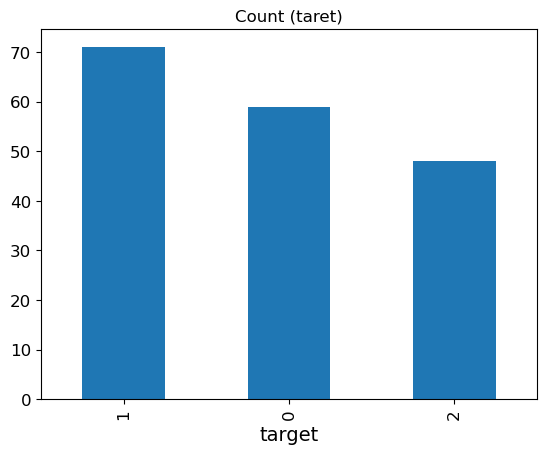

In [10]:
target_class_counts.plot(kind="bar", title="Count (taret)", grid=False)

**Spotlights**

The graph confirms the number of categorical observations printed above. 

- Class 0: 59
- Class 1: 71
- Calls 2: 48
  

## Separate the Dataset

Instead of employing the holdout method to divide the datasets into training and test sets, cross-validation will be utilize for training the data. The dependent variable, referred to as 'target', represents the value that needs to be predicted. Consequently, it will be extracted from the training dataset and placed into a distinct DataFrame designated for labels.At this stage, it is simply a matter of isolating the labels from the training set (X) and storing them in a separate vector (y).

In [11]:
# Create label columns
labels = ["target"]

# Create predictors list
predictors = [
    "alcohol",
    "malic_acid",
    "ash",
    "alcalinity_of_ash",
    "magnesium",
    "total_phenols",
    "flavanoids",
    "nonflavanoid_phenols",
    "proanthocyanins",
    "color_intensity",
    "hue",
    "od280/od315_of_diluted_wines",
    "proline",
]

X, y = df[predictors], df[labels]

**Compare the number of columns in the original data to the new training and label sets.**

In [12]:
print(f"Original set:    {df.shape}")
print("------------------------------")
print(f"Training data:   {X.shape}")
print(f"Training labels: {y.shape}")

Original set:    (178, 14)
------------------------------
Training data:   (178, 13)
Training labels: (178, 1)
